## Regularization and Hyperparamter Optimization

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def select(query):
    
    conn = sqlite3.connect('./data/lending-club-loan-data/database2.sqlite')
    cursor = conn.cursor()
    temp_df = pd.DataFrame(cursor.execute(query).fetchall())
    temp_df.columns = list(map(lambda x: x[0], cursor.description))
    conn.close()
    
    return temp_df.copy()

In [3]:
features_train = select('SELECT * FROM FEATURES_TRAIN')
targets_train = select('SELECT * FROM TARGETS_TRAIN')
features_test = select('SELECT * FROM FEATURES_TEST')
targets_test = select('SELECT * FROM TARGETS_TEST')

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

In [5]:
# our scoring functions will all focus on the negative class -- we already know the model performs well on the positive class
# we are looking to optimize model performance on the negative examples. we will eventually have to consider model
# performance on the positive class as well -- can't sacrifice too much of the predictability on positives

# F1 score on the negative class may intuitively seem to be the best metric to optimize for, but in the context of loan
# portfolio optimization, it may be more important to detect bad loans -- i.e. maximize recall on the negative class,
# even if it means reduced precision and F1 (classifying many good loans as bad)

def neg_f1(targets_true,targets_predicted):
    tn, fp, fn, tp = confusion_matrix(targets_true,targets_predicted).ravel()
    precision = tn/(tn+fn)
    recall = tn/(tn+fp)
    return 2*(precision*recall)/(precision+recall)

def neg_precision(targets_true,targets_predicted):
    tn, fp, fn, tp = confusion_matrix(targets_true,targets_predicted).ravel()
    return tn/(tn+fn)

def neg_recall(targets_true,targets_predicted):
    tn, fp, fn, tp = confusion_matrix(targets_true,targets_predicted).ravel()
    return tn/(tn+fp)

---
### Logistic Regression

In [6]:
lr = LogisticRegression().fit(features_train,targets_train.loan_status)
neg_f1(targets_test.loan_status,lr.predict(features_test))

0.00044777790216052836

In [93]:
# optimize for F1, precision, recall

params = {'C':[.0001,.001,.01,.1,1,10,100,1000]}

lr = LogisticRegression()

clfF1 = GridSearchCV(lr,param_grid=params,scoring=make_scorer(neg_f1),return_train_score=True)\
    .fit(features_train,targets_train.loan_status)
clfPREC = GridSearchCV(lr,param_grid=params,scoring=make_scorer(neg_precision),return_train_score=True)\
    .fit(features_train,targets_train.loan_status)
clfREC = GridSearchCV(lr,param_grid=params,scoring=make_scorer(neg_recall),return_train_score=True)\
    .fit(features_train,targets_train.loan_status)

In [94]:
# we see in the three cells below that regularization on logistic regression does not do much to help the performance
# of the model. the effect of the inherent data imbalance greatly limits performance

pd.DataFrame(clfF1.cv_results_).sort_values('mean_test_score',ascending=False)[['mean_test_score','param_C']]

,mean_test_score,param_C
0,0.020515,0.0001
4,0.013888,1
1,0.012683,0.001
3,0.006705,0.1
7,0.002282,1000
5,0.002172,10
6,0.001117,100
2,0.000838,0.01


In [95]:
# the two best C values are the opposite edge cases.. odd behavior

pd.DataFrame(clfPREC.cv_results_).sort_values('mean_test_score',ascending=False)[['mean_test_score','param_C']]

,mean_test_score,param_C
7,0.598389,1000
1,0.548325,0.001
6,0.539683,100
2,0.498932,0.01
3,0.480212,0.1
0,0.473994,0.0001
5,0.451000,10
4,0.437638,1


In [96]:
pd.DataFrame(clfREC.cv_results_).sort_values('mean_test_score',ascending=False)[['mean_test_score','param_C']]

,mean_test_score,param_C
0,0.010705,0.0001
4,0.007239,1
1,0.006596,0.001
3,0.003410,0.1
7,0.001146,1000
5,0.001090,10
6,0.000559,100
2,0.000419,0.01


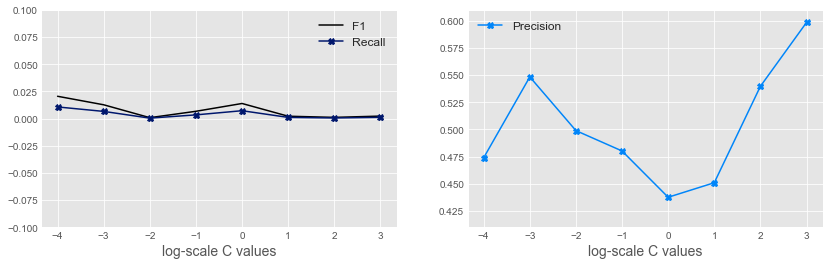

In [143]:
# the plots have the same scale on the y-axis to show the degree of difference in model performance variation

fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(pd.DataFrame(clfF1.cv_results_)['param_C'].apply(lambda x: np.log10(x))\
        ,pd.DataFrame(clfF1.cv_results_)['mean_test_score'],'k-')
ax1.plot(pd.DataFrame(clfREC.cv_results_)['param_C'].apply(lambda x: np.log10(x))\
        ,pd.DataFrame(clfREC.cv_results_)['mean_test_score'],'X-',color='#00176d')
ax1.legend(['F1','Recall'],fontsize=12)
ax1.set_ylim([-0.1,0.1])
ax1.set_xlabel('log-scale C values',fontsize=14)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(pd.DataFrame(clfPREC.cv_results_)['param_C'].apply(lambda x: np.log10(x))\
        ,pd.DataFrame(clfPREC.cv_results_)['mean_test_score'],'X-',color='#0085f9')
ax2.legend(['Precision'],fontsize=12)
ax2.set_ylim([0.41,0.61])
ax2.set_xlabel('log-scale C values',fontsize=14)

#plt.savefig('./report/hyperparams-lr.jpg')

In [11]:
# models perform with respect to F1, precision, and recall about as poorly as they did without regularization

print(neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test)))
print(neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test)))
print(neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test)))

0.000447777902161
0.466666666667
0.000223989248516


In [12]:
LRF1 = neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test))
LRPREC = neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test))
LRREC = neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test))

---
### Gaussian Naive-Bayes

In [13]:
from sklearn.naive_bayes import GaussianNB

In [14]:
# when estimated by the data (by default), class prior probabilities of GNB are the proportions of each class
# we can tinker with the prior probabilities to increase the model's sensitivity to certain classes. this should
# intuitively have a similar effect as resampling the dataset input to GNB without adjusting the default priors

# the first value in each pair is the prior probability of the negative class

params = {'priors':[[0.1,0.9],[0.2,0.8],[0.3,0.7],[0.4,0.6],[0.5,0.5],[0.6,0.4]]}

GNB = GaussianNB()

clfF1 = GridSearchCV(GNB,param_grid=params,scoring=make_scorer(neg_f1),return_train_score=True)\
    .fit(features_train,targets_train.loan_status)
clfPREC = GridSearchCV(GNB,param_grid=params,scoring=make_scorer(neg_precision),return_train_score=True)\
    .fit(features_train,targets_train.loan_status)
clfREC = GridSearchCV(GNB,param_grid=params,scoring=make_scorer(neg_recall),return_train_score=True)\
    .fit(features_train,targets_train.loan_status)

In [15]:
# for a balance between precision and recall, it seems about an even balance on prior probabilities is optimal

pd.DataFrame(clfF1.cv_results_).sort_values('mean_test_score',ascending=False)[['mean_test_score','param_priors']]

,mean_test_score,param_priors
4,0.373224,"[0.5, 0.5]"
5,0.367746,"[0.6, 0.4]"
3,0.367621,"[0.4, 0.6]"
2,0.351018,"[0.3, 0.7]"
1,0.327848,"[0.2, 0.8]"
0,0.268723,"[0.1, 0.9]"


In [16]:
# precision and recall have opposite orderings of param values. it seems that we can reduce precision for greater recall
# and vice versa. indeed, this is a very similar result to what happened with undersampling

pd.DataFrame(clfPREC.cv_results_).sort_values('mean_test_score',ascending=False)[['mean_test_score','param_priors']]

,mean_test_score,param_priors
0,0.357363,"[0.1, 0.9]"
1,0.325372,"[0.2, 0.8]"
2,0.302458,"[0.3, 0.7]"
3,0.285865,"[0.4, 0.6]"
4,0.267287,"[0.5, 0.5]"
5,0.246101,"[0.6, 0.4]"


In [17]:
pd.DataFrame(clfREC.cv_results_).sort_values('mean_test_score',ascending=False)[['mean_test_score','param_priors']]

,mean_test_score,param_priors
5,0.728144,"[0.6, 0.4]"
4,0.619088,"[0.5, 0.5]"
3,0.515315,"[0.4, 0.6]"
2,0.418306,"[0.3, 0.7]"
1,0.330436,"[0.2, 0.8]"
0,0.215344,"[0.1, 0.9]"


In [18]:
# f1 and recall are much better than in logistic regression, as seen in the baseline model w/o resampling

print(neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test)))
print(neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test)))
print(neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test)))

0.367787323277
0.35449833395
0.722589315713


In [19]:
GNBF1 = neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test))
GNBPREC = neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test))
GNBREC = neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test))

---
### k Nearest Neighbors

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [152]:
# this takes a while to compute.. commenting to remove code from future runs

params = {'n_neighbors':list(range(1,11))+[12,15,20,27,35]}

kNN = KNeighborsClassifier()

#clfF1 = GridSearchCV(kNN,param_grid=params,scoring=make_scorer(neg_f1),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)
#clfPREC = GridSearchCV(kNN,param_grid=params,scoring=make_scorer(neg_precision),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)
#clfREC = GridSearchCV(kNN,param_grid=params,scoring=make_scorer(neg_recall),return_train_score=True)\
#    .fit(features_train,targets_train.loan_status)

In [153]:
#pd.DataFrame(clfF1.cv_results_).to_csv('./data/re-knn-f1.csv')
#pd.DataFrame(clfPREC.cv_results_).to_csv('./data/re-knn-prec.csv')
#pd.DataFrame(clfREC.cv_results_).to_csv('./data/re-knn-rec.csv')

In [154]:
# overall performance is much weaker than Gaussian Naive-Bayes

pd.read_csv('./data/re-knn-f1.csv').drop('Unnamed: 0',axis=1)\
    .sort_values('mean_test_score',ascending=False)[['mean_test_score','param_n_neighbors']]

,mean_test_score,param_n_neighbors
1,0.255185,2
3,0.205052,4
0,0.203513,1
5,0.152544,6
2,0.150728,3
7,0.119035,8
4,0.107831,5
9,0.091316,10
6,0.081866,7
10,0.071858,12


In [155]:
# greater number of neighbors tends to increase precision of model

pd.read_csv('./data/re-knn-prec.csv').drop('Unnamed: 0',axis=1)\
    .sort_values('mean_test_score',ascending=False)[['mean_test_score','param_n_neighbors']]

,mean_test_score,param_n_neighbors
14,0.337669,35
12,0.300189,20
13,0.297018,27
11,0.282426,15
10,0.269905,12
9,0.259177,10
8,0.257330,9
6,0.248811,7
7,0.246623,8
4,0.230260,5


In [157]:
pd.read_csv('./data/re-knn-rec.csv').drop('Unnamed: 0',axis=1)\
    .sort_values('mean_test_score',ascending=False)[['mean_test_score','param_n_neighbors']]

,mean_test_score,param_n_neighbors
1,0.356875,2
0,0.203130,1
3,0.193013,4
5,0.114589,6
2,0.114254,3
7,0.078452,8
4,0.070402,5
9,0.055422,10
6,0.048994,7
10,0.041448,12


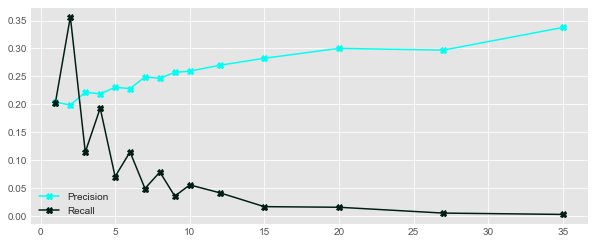

In [173]:
# as we increase k, the recall approaches 0. this is very likely because of the class imbalance. since there are so few
# minority class samples (dispersed in a sea of majority class samples), most of their neighbors will be majority class samples. 
# thus, only the samples in the very densest regions of the minority class will get classified correctly.

# it would be interesting to apply resampling and test this idea ^ (this is definitely worth doing--as an exploration of
# combining resampling with hyperparameter optimization)

fig, ax = plt.subplots(1,1,figsize=(10,4))

ax.plot(pd.read_csv('./data/re-knn-prec.csv')['param_n_neighbors'],\
        pd.read_csv('./data/re-knn-prec.csv')['mean_test_score'],'X-',color='#00fff2')
ax.plot(pd.read_csv('./data/re-knn-rec.csv')['param_n_neighbors'],\
        pd.read_csv('./data/re-knn-rec.csv')['mean_test_score'],'X-',color='#001e14')
ax.legend(['Precision','Recall','f1'])

In [ ]:
# increases in precision seem to diminish quickly on both the test set and training set

kNN1 = KNeighborsClassifier(n_neighbors=70).fit(features_train,targets_train.loan_status)
neg_precision(targets_test.loan_status,kNN1.predict(features_test))

In [29]:
print(neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test)))
print(neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test)))
print(neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test)))

0.25316759263
0.263157894737
0.354686975025


In [30]:
kNNF1 = neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test))
kNNPREC = neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test))
kNNREC = neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test))

---
### Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
# more estimators (trees) in a RF generally result in better performance, at computational expense. we leave this out
# of the grid search (too long to compute, otherwise) and isolate the other parameters
# param values are chosen somewhat haphazardly for this initial run. simply want to see trends w/ varying values
# choosing few values because this is too computationally expensive to run on more

# also commenting to remove from future runs

params = {'min_samples_split':[2,8,32],'min_samples_leaf':[1,16,32]}

RF = RandomForestClassifier()

clfF1 = GridSearchCV(RF,param_grid=params,scoring=make_scorer(neg_f1),return_train_score=True)\
    .fit(features_train,targets_train.loan_status)
clfPREC = GridSearchCV(RF,param_grid=params,scoring=make_scorer(neg_precision),return_train_score=True)\
    .fit(features_train,targets_train.loan_status)
clfREC = GridSearchCV(RF,param_grid=params,scoring=make_scorer(neg_recall),return_train_score=True)\
    .fit(features_train,targets_train.loan_status)

In [70]:
#pd.DataFrame(clfF1.cv_results_).to_csv('./data/re-rf-f1.csv')
#pd.DataFrame(clfPREC.cv_results_).to_csv('./data/re-rf-prec.csv')
#pd.DataFrame(clfREC.cv_results_).to_csv('./data/re-rf-rec.csv')

In [72]:
# for both F1 and recall, it seems tweaking the min samples does not help model performance 
# (in fact it seems to greatly reduce it..) the default values of 1 and 2 seem best

pd.read_csv('./data/re-rf-f1.csv').drop('Unnamed: 0',axis=1).sort_values('mean_test_score',ascending=False)[['mean_test_score',
                                                                                'param_min_samples_leaf',
                                                                                'param_min_samples_split']]

,mean_test_score,param_min_samples_leaf,param_min_samples_split
0,0.213364,1,2
1,0.149354,1,8
2,0.100027,1,32
4,0.072066,16,8
5,0.072056,16,32
3,0.068750,16,2
8,0.053418,32,32
6,0.051426,32,2
7,0.049348,32,8


In [73]:
# for precision, however, adjusting the min samples in a leaf seems to greatly increase the model's performance

pd.read_csv('./data/re-rf-prec.csv').drop('Unnamed: 0',axis=1).sort_values('mean_test_score',ascending=False)[['mean_test_score',
                                                                                'param_min_samples_leaf',
                                                                                'param_min_samples_split']]

,mean_test_score,param_min_samples_leaf,param_min_samples_split
6,0.508881,32,2
7,0.488280,32,8
8,0.483929,32,32
3,0.478942,16,2
5,0.474686,16,32
4,0.469063,16,8
2,0.431151,1,32
1,0.378049,1,8
0,0.334643,1,2


In [66]:
# the precision performance jumps around quite a bit as we vary minimum samples in leaeves, 
# but we are able to achieve an 'OK' level of precision (around ~0.5) on the test set..not bad

RF1 = RandomForestClassifier(min_samples_leaf=60,random_state=10).fit(features_train,targets_train.loan_status)
print(neg_precision(targets_test.loan_status,RF1.predict(features_test)))
print((RF1.predict(features_test)-1).sum()*-1)

0.5
356


In [74]:
pd.read_csv('./data/re-rf-rec.csv').drop('Unnamed: 0',axis=1).sort_values('mean_test_score',ascending=False)[['mean_test_score',
                                                                                'param_min_samples_leaf',
                                                                                'param_min_samples_split']]

,mean_test_score,param_min_samples_leaf,param_min_samples_split
0,0.159726,1,2
1,0.091923,1,8
2,0.057909,1,32
3,0.039575,16,2
4,0.038541,16,8
5,0.036780,16,32
8,0.027753,32,32
6,0.027250,32,2
7,0.026970,32,8


In [68]:
print(neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test)))
print(neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test)))
print(neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test)))

0.211616046281
0.464435146444
0.159256355695


In [69]:
RFF1 = neg_f1(targets_test.loan_status,clfF1.best_estimator_.predict(features_test))
RFPREC = neg_precision(targets_test.loan_status,clfPREC.best_estimator_.predict(features_test))
RFREC = neg_recall(targets_test.loan_status,clfREC.best_estimator_.predict(features_test))

## Summary

In [ ]:
# visualize summary